In [14]:
# Autoreload possibly interferes with IntelliJ debugging
%reload_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = lambda msg: logging.info(msg)


# Full night pipeline (multiple files)

In [15]:
import pandas as pd
import os

input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")

# Find Brainflow files that haven't been copied over

In [16]:
import pytz
from tqdm import tqdm
import paramiko
import re
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()

# Define the time window
time_window = timedelta(minutes=10)

# Define the remote server details
hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')
remote_dir = '/home/graham/dev/Brainwave-Data'
local_dir = input_dir

# Create an SSH client
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password, compress=True)

# List files in the remote directory
stdin, stdout, stderr = ssh.exec_command(f'ls {remote_dir}')
remote_brainflow_files = [f for f in stdout.read().decode().splitlines() if f.endswith(".brainflow.csv")]


2024-11-15 09:46:54,704 - INFO - Connected (version 2.0, client OpenSSH_9.6)
2024-11-15 09:46:54,832 - INFO - Authentication (publickey) failed.
2024-11-15 09:46:54,892 - INFO - Authentication (password) successful!


In [17]:
remote_brainflow_files

['2024-09-30-21-27-49.brainflow.csv',
 '2024-10-01-21-36-11.brainflow.csv',
 '2024-10-02-21-20-34.brainflow.csv',
 '2024-10-02-21-21-15.brainflow.csv',
 '2024-10-04-21-13-39.brainflow.csv',
 '2024-10-05-21-09-47.brainflow.csv',
 '2024-10-06-21-29-18.brainflow.csv',
 '2024-10-07-21-35-18.brainflow.csv',
 '2024-10-08-21-21-34.brainflow.csv',
 '2024-10-09-21-22-04.brainflow.csv',
 '2024-10-11-21-16-27.brainflow.csv',
 '2024-10-15-22-01-52.brainflow.csv',
 '2024-10-20-20-09-48.brainflow.csv',
 '2024-10-21-21-30-19.brainflow.csv',
 '2024-10-23-21-24-03.brainflow.csv',
 '2024-10-24-21-35-33.brainflow.csv',
 '2024-10-29-20-42-12.brainflow.csv',
 '2024-10-30-21-26-55.brainflow.csv',
 '2024-11-01-21-32-22.brainflow.csv',
 '2024-11-02-21-29-03.brainflow.csv',
 '2024-11-03-21-20-37.brainflow.csv',
 '2024-11-04-21-20-51.brainflow.csv',
 '2024-11-05-21-34-15.brainflow.csv',
 '2024-11-07-21-26-18.brainflow.csv',
 '2024-11-08-21-16-53.brainflow.csv',
 '2024-11-09-21-27-51.brainflow.csv',
 '2024-11-12

In [18]:
files_to_copy = remote_brainflow_files.copy()

for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if ".brainflow.csv.bz2" in full_input_filename:
            file_name_without_bz2 = file_name.removesuffix(".bz2")
            already_have = file_name_without_bz2 in remote_brainflow_files
            print(f"Already have {full_input_filename}: {already_have}")
            if already_have:
                files_to_copy.remove(file_name_without_bz2)



Already have C:\dev\play\brainwave-data\08-07-2024--22-51-16\08-07-2024--22-51-16.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\09-07-2024--22-52-25\09-07-2024--22-52-25.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-15-09-10-07\2024-07-15-09-10-07.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-16-23-14-52\2024-07-16-23-14-52.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-24-18-57-03\2024-07-24-18-57-03.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-03-21-10-58\2024-09-03-21-10-58.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-04-21-44-08\2024-09-04-21-44-08.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-08-21-01-39\2024-09-08-21-01-39.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-10-21-22-21\2024-09-10-21-22-21.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-11-

In [19]:
files_to_copy

[]

In [20]:
import os
import bz2
from tqdm import tqdm

sftp = ssh.open_sftp()
for file in files_to_copy:
    remote_file_path = remote_dir + "/" + file
    local_file_path = os.path.join(input_dir, file)
    log(f"Copying Brainflow backup {remote_file_path} to {local_file_path}")

    # Get the file size
    remote_file_size = sftp.stat(remote_file_path).st_size

    with tqdm(total=remote_file_size, unit='B', unit_scale=True, desc=file, ascii=True) as pbar:
        local_file_path = os.path.join(input_dir, file)
    
        def callback(transferred_so_far, total_to_transfer):
            pbar.update(transferred_so_far - pbar.n)
    
        # Create a file-like object that writes to the local file
        with open(local_file_path, 'wb') as local_file:
            sftp.getfo(remote_file_path, local_file, callback=callback)
sftp.close()

2024-11-15 09:46:56,610 - INFO - [chan 1] Opened sftp connection (server version 3)
2024-11-15 09:46:56,614 - INFO - [chan 1] sftp session closed.


In [21]:
ssh.close()


## Convert Brainflow files to FIF

In [22]:
def get_brainflow_compressed_filename(full_input_filename: str) -> str:
    full_output_dirname = webserver.output_dirname(full_input_filename)
    compressed_full_output_filename = str(os.path.join(full_output_dirname, os.path.basename(full_input_filename))) + '.bz2'
    return compressed_full_output_filename

In [23]:
from datetime import datetime

import webserver
import convert
# import zstandard as zstd
import os
import bz2
import time
import shutil

errors = []
processed = []

# Could get these working later
skip_list = ['2024-09-10-21-22-21']

def compress_bz2(input_file, output_file):
    start_time = time.time()
    with open(input_file, 'rb') as f_in:
        with bz2.open(output_file, 'wb', compresslevel=9) as f_out:
            shutil.copyfileobj(f_in, f_out)
    end_time = time.time()
    return end_time - start_time, os.path.getsize(output_file)

for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        try:
            if full_input_filename.endswith(".brainflow.csv"):
                full_output_dirname = webserver.output_dirname(full_input_filename)
                full_output_filename = str(os.path.join(full_output_dirname, 'raw.fif'))
                
                compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
                if not os.path.exists(compressed_full_output_filename):
                    log(f"Compressing file {full_input_filename} to " + compressed_full_output_filename)
                    processed.append("Compressing " + full_input_filename)
                    try:
                        os.mkdir(os.path.dirname(compressed_full_output_filename))
                    except:
                        pass
                    compress_bz2(full_input_filename, compressed_full_output_filename) 
                    
                if os.path.exists(full_output_filename):
                    log(f"Skipping file {full_input_filename} as {full_output_filename} and {compressed_full_output_filename} already exist")
                    continue
                should_skip = False
                for s in skip_list:
                    if s in full_input_filename:
                        log(f"Skipping file {full_input_filename}")
                        should_skip = True
                if not should_skip:
                    log(f"Processing file {full_input_filename}")
                    processed.append("Processing " + full_input_filename)
                    channels = None
                    date_time_str = os.path.basename(full_input_filename).removesuffix(".brainflow.csv")
                    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d-%H-%M-%S')
                    if (date_time_obj > datetime(2024, 9, 1, 0, 0, 0)):
                        channels = ['Fpz-M1']
        
                    if channels is not None:
                        log(f"Processing file {full_input_filename} with channels {channels}")
                        convert.convert_and_save_brainflow_file(log, full_input_filename, full_output_filename, channels)

        except Exception as e:
            msg = "Error processing file: " + full_input_filename
            log(msg)
            log(e)
            errors.append(msg)


2024-11-15 09:46:57,509 - INFO - Skipping file C:\dev\play\brainwave-data\2024-10-02-21-20-34.brainflow.csv as C:\dev\play\brainwave-data\2024-10-02-21-20-34\raw.fif and C:\dev\play\brainwave-data\2024-10-02-21-20-34\2024-10-02-21-20-34.brainflow.csv.bz2 already exist
2024-11-15 09:46:57,510 - INFO - Skipping file C:\dev\play\brainwave-data\2024-10-06-21-29-18.brainflow.csv as C:\dev\play\brainwave-data\2024-10-06-21-29-18\raw.fif and C:\dev\play\brainwave-data\2024-10-06-21-29-18\2024-10-06-21-29-18.brainflow.csv.bz2 already exist
2024-11-15 09:46:57,511 - INFO - Skipping file C:\dev\play\brainwave-data\2024-10-08-21-21-34.brainflow.csv as C:\dev\play\brainwave-data\2024-10-08-21-21-34\raw.fif and C:\dev\play\brainwave-data\2024-10-08-21-21-34\2024-10-08-21-21-34.brainflow.csv.bz2 already exist
2024-11-15 09:46:57,511 - INFO - Skipping file C:\dev\play\brainwave-data\2024-10-09-21-22-04.brainflow.csv as C:\dev\play\brainwave-data\2024-10-09-21-22-04\raw.fif and C:\dev\play\brainwave-d

In [24]:
errors

[]

In [25]:
processed

['Processing C:\\dev\\play\\brainwave-data\\2024-11-12-21-11-43.brainflow.csv']

## Run pipeline on FIF files

2024-11-15 09:49:23,307 - INFO - Processing file: C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif
2024-11-15 09:49:23,308 - INFO - Processing file: C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.fif
2024-11-15 09:49:23,309 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif
2024-11-15 09:49:23,310 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif
2024-11-15 09:49:23,310 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.fif
2024-11-15 09:49:23,310 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.fif
2024-11-15 09:49:23,311 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.fif
2024-11-15 09:49:23,312 - INFO - Processing file: C:\dev\play\brainwave-data\2024-07-15-09-10-07\raw.fif
2024-11-15 09:49:23,313 - INFO - Loading cached file C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.with_features.csv
2024-11-15 09:49:23,313 - INFO - Pro

Setting up band-pass filter from 0.3 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 1.60 Hz)
- Filter length: 4125 samples (16.500 s)



2024-11-15 09:49:34,864 - INFO - Memory Usage: 1394.77 MB GC to 1394.77 MB
2024-11-15 09:49:34,865 - INFO - Running YASA
2024-11-15 09:49:35,038 - INFO - Memory Usage: 1394.77 MB GC to 1394.77 MB
2024-11-15 09:49:39,281 - WARNING - Hypnogram is SHORTER than data by 16.59 seconds. Padding hypnogram with last value to match data.size.
2024-11-15 09:49:48,745 - INFO - Writing to C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.sleep_stages.csv
2024-11-15 09:49:48,894 - INFO - Memory Usage: 1593.12 MB GC to 1593.12 MB
2024-11-15 09:49:48,895 - INFO - Processing sleep statistics
2024-11-15 09:49:49,033 - INFO - Memory Usage: 1593.12 MB GC to 1593.12 MB
2024-11-15 09:49:49,033 - INFO - Processing sleep stability
2024-11-15 09:49:49,173 - INFO - Memory Usage: 1593.12 MB GC to 1593.12 MB


Setting up band-pass filter from 0.3 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 1.60 Hz)
- Filter length: 4125 samples (16.500 s)



2024-11-15 09:49:56,319 - INFO - Memory Usage: 1649.70 MB GC to 1605.44 MB
2024-11-15 09:49:56,321 - INFO - YASA all done!
2024-11-15 09:49:56,466 - INFO - Memory Usage: 1536.80 MB GC to 1536.83 MB
C:\dev\play\brainwave-processor\scaling.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[renamed] = df[col]
C:\dev\play\brainwave-processor\scaling.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[renamed] = df[col]
C:\dev\play\brainwave-processor\scaling.py:77: PerformanceWarning: DataFrame is highly fragmented.  This i

1/1 [==============================] - 6s 6s/step
Saved microwakings to: C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.microwakings.csv
Channel
(1, 8996648)
0
Padding needed -2
8996648
Upsampled channel: 8996648
Orig (1, 8996648)
(1, 8996648)
1
8996648


2024-11-15 09:50:11,886 - INFO - Exporting to: C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.edf
2024-11-15 09:50:12,615 - INFO - All done! C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.fif
2024-11-15 09:50:12,630 - INFO - Got result       Stage  Confidence  Epoch                           Timestamp  Source  \
epoch                                                                        
0         W    0.998900      0 2024-11-12 21:11:43.812747955+00:00  Fpz-M1   
1         W    0.999712      1 2024-11-12 21:12:13.812747955+00:00  Fpz-M1   
2         W    0.999857      2 2024-11-12 21:12:43.812747955+00:00  Fpz-M1   
3         W    0.999903      3 2024-11-12 21:13:13.812747955+00:00  Fpz-M1   
4         W    0.999559      4 2024-11-12 21:13:43.812747955+00:00  Fpz-M1   
...     ...         ...    ...                                 ...     ...   
1194      W    0.912815   1194 2024-11-13 07:08:43.812747955+00:00  Fpz-M1   
1195      W    0.573320   1195 2024-11-13 07:09:13.812

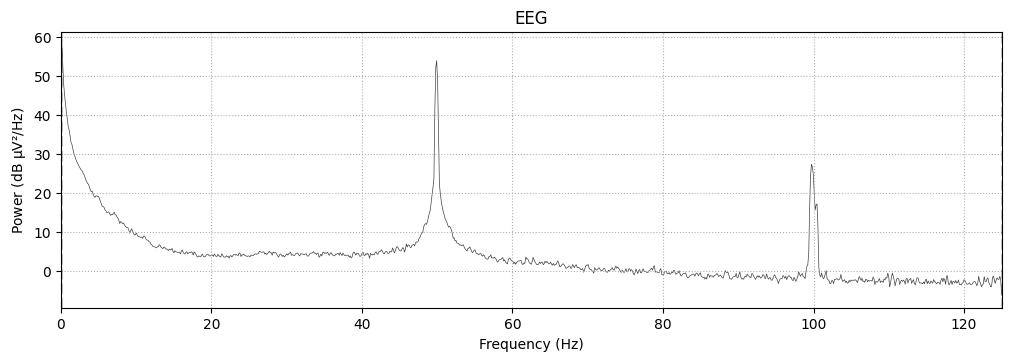

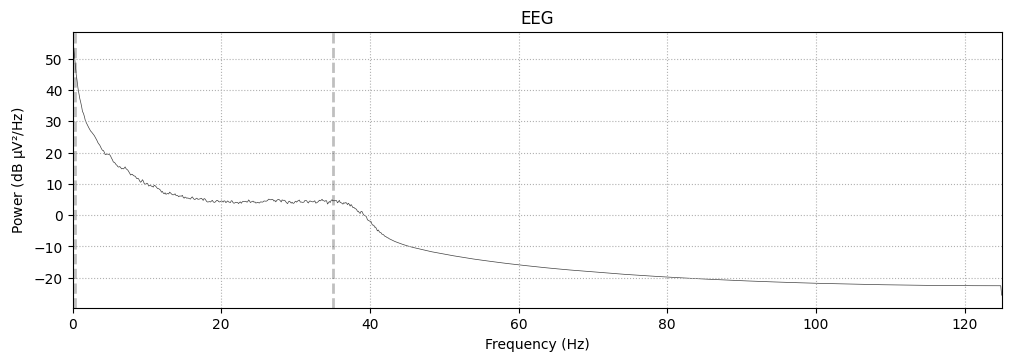

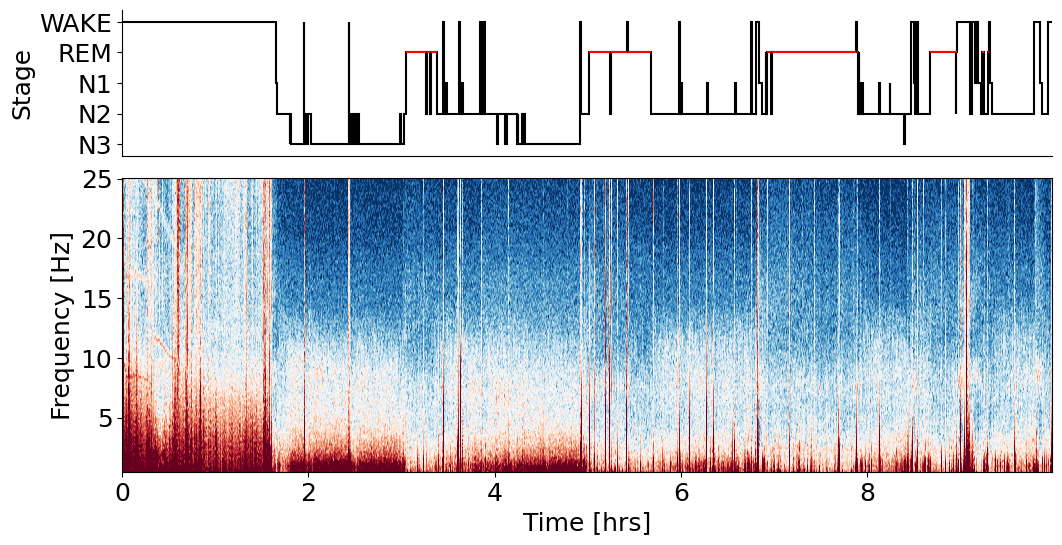

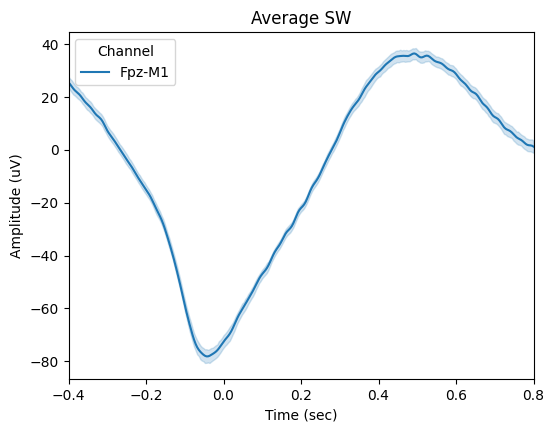

In [26]:
import pandas as pd
import run_feature_pipeline
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

errors = []
dataframes = []

# Could get these working later
skip_list = ['2024-07-23-22-40-25', '2024-07-28-22-29-49', '2024-09-18-21-25-08', '2024-09-18-21-28-11', '2024-09-19-21-29-42']

def process_file(root, dir_name):
    input_file = os.path.join(root, dir_name, "raw.fif")
    if dir_name in skip_list:
        log(f"Skipping {dir_name}: " + input_file)
        return None
    try:
        log(f"Processing file: " + input_file)
        if os.path.exists(input_file):
            yasa_df = run_feature_pipeline.cached_pipeline(log, input_file, stats_df)
            #log(f"Returning {yasa_df.head()}")
            return yasa_df
    except Exception as e:
        msg = f"Error processing file: " + input_file + " - " + str(e)
        log(msg)
        errors.append(msg)
        log(e)
    return None

with ThreadPoolExecutor() as executor:
    futures = []
    for root, dirs, files in os.walk(input_dir):
        for dir_name in dirs:
            futures.append(executor.submit(process_file, root, dir_name))

    for future in as_completed(futures):
        result = future.result()
        log(f"Got result {result}")
        if result is not None:
            dataframes.append(result)

all = pd.concat(dataframes)
log(f"Finished processing, have {len(all)} files in total")

In [27]:
dataframes

[      Stage  Confidence  Epoch                            Timestamp Source  \
 epoch                                                                        
 0         W    0.999805      0  2024-07-21 22:22:16.633243084+01:00  F8-M1   
 1         W    0.999764      1  2024-07-21 22:22:46.633243084+01:00  F8-M1   
 2         W    0.999902      2  2024-07-21 22:23:16.633243084+01:00  F8-M1   
 3         W    0.999798      3  2024-07-21 22:23:46.633243084+01:00  F8-M1   
 4         W    0.999562      4  2024-07-21 22:24:16.633243084+01:00  F8-M1   
 ...     ...         ...    ...                                  ...    ...   
 1007      W    0.815535   1007  2024-07-22 06:45:46.633243084+01:00  F8-M1   
 1008      W    0.987205   1008  2024-07-22 06:46:16.633243084+01:00  F8-M1   
 1009      W    0.906253   1009  2024-07-22 06:46:46.633243084+01:00  F8-M1   
 1010      W    0.913744   1010  2024-07-22 06:47:16.633243084+01:00  F8-M1   
 1011      W    0.959268   1011  2024-07-22 06:47:46

In [28]:
errors

['Error processing file: C:\\dev\\play\\brainwave-data\\2024-10-02-21-20-34\\raw.fif - Sliding window size may not exceed size of selected axis']

# Recalculate scalings
N.b. can be run frequently but will only be picked up by new runs.  Maybe worth occasionally regenerating all old files.
And yes, for new features have to rerun the pipeline on everything, then generate the stats here, then rerun the pipeline again on everything to have them use those.

In [29]:
from scaling import only_eeg

only_eeg_cols = list(only_eeg(all).columns)
assert any(col.startswith("Main") for col in only_eeg_cols), "No column starting with 'Main' found in only_eeg_cols"

In [30]:
import scaling

stats = scaling.stats(all)
stats.to_csv(input_dir + "/stats.csv")
assert any(stats['Column'].str.startswith("Main")), "No row starting with 'Main' found in column_name"
stats

C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: inva

,Column,Mean,P10,P90,Min,Max,StdDev
0,F8-M1_eeg_abspow,1.921968e-07,4.772690e-11,9.516579e-10,8.534915e-35,0.000777,0.000009
1,F8-M1_eeg_abspow_c7min_norm,4.070216e+01,-8.968809e-02,5.672409e-01,-2.093740e-01,47832.670000,848.154728
2,F8-M1_eeg_abspow_p2min_norm,4.897505e+01,-6.837685e-02,5.577247e-01,-2.503299e-01,79046.375000,1356.728153
3,F8-M1_eeg_alpha,6.848900e-02,1.244090e-02,1.253551e-01,8.034852e-05,0.398397,0.048033
4,F8-M1_eeg_alpha_c7min_norm,-3.206412e-02,-5.190218e-01,3.788195e-01,-7.588421e-01,1.428529,0.332931
...,...,...,...,...,...,...,...
1579,F4-M1_eeg_thetaabsaa_c7min_norm_s,4.794772e+01,2.617300e-08,1.000000e+00,-2.436636e-01,18774.540000,822.069211
1580,F4-M1_eeg_thetaabsaa_p2min_norm_s,3.758289e+01,-5.120000e-09,1.000000e+00,-2.748624e-01,28302.000000,1021.445548
1581,F4-M1_eeg_thetaabsab_s,2.023182e+02,-1.619700e-09,1.000000e+00,-3.467280e-02,450000.660000,9409.660819
1582,F4-M1_eeg_thetaabsab_c7min_norm_s,2.356170e+01,6.504800e-09,9.999999e-01,-3.952644e-02,9183.251000,401.182797


# Post-human processing
This requires user interaction first to provide sleep times etc.

In [31]:
from sleep_events import load_days_data
from sleep_events import pimp_my_days_data

days_data = load_days_data(True)

In [32]:
from models.eeg_states.eeg_states import load_and_prepare_eeg_state_events

eeg_state_events = load_and_prepare_eeg_state_events()

ImportError: cannot import name 'load_and_prepare_eeg_state_events' from 'models.eeg_states.eeg_states' (C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py)

In [ ]:
# from run_post_human_pipeline import cached_post_human_pipeline
# import run_feature_pipeline
# 
# dir_name = "2024-11-01-21-32-22"
# input_file = f"C:\\dev\\play\\brainwave-data\\{dir_name}\\raw.fif"
# yasa_df = run_feature_pipeline.cached_pipeline(log, input_file, stats_df)
# post_human_df = cached_post_human_pipeline(log, dir_name, input_file, stats_df, days_data, yasa_df, eeg_state_events)
# post_human_df

In [21]:
from run_post_human_pipeline import cached_post_human_pipeline

errors = []

for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(dirs):
        input_file = os.path.join(root, dir_name, "raw.fif")
        try:
            log("Processing file: " + input_file)
            input_file_without_ext = os.path.splitext(input_file)[0]

            if dir_name in skip_list:
                log(f"Skipping {idx} of {len(dirs)}: " + input_file)
                continue

            if os.path.exists(input_file):
                yasa_df = run_feature_pipeline.cached_pipeline(log, input_file, stats_df)
                post_human_df = cached_post_human_pipeline(log, dir_name, input_file, stats_df, days_data, yasa_df, eeg_state_events)

                output_csv_file = input_file_without_ext + ".post_human.csv"
                log("Saving to: " + output_csv_file)
                post_human_df.to_csv(output_csv_file, index=False)

        except Exception as e:
            log("Error processing file: " + input_file)
            errors.append("Error processing file: " + input_file + " - " + str(e))
            log(e)

for err in errors:
    log(err)


2024-11-12 17:25:14,670 - INFO - Processing file: C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.fif
2024-11-12 17:25:14,670 - INFO - Loading cached file C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.with_features.csv
2024-11-12 17:25:14,778 - INFO - Loading cached file C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.post_human.csv
2024-11-12 17:25:14,876 - INFO - Saving to: C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.post_human.csv
2024-11-12 17:25:15,402 - INFO - Processing file: C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.fif
2024-11-12 17:25:15,403 - INFO - Loading cached file C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.with_features.csv
2024-11-12 17:25:15,528 - INFO - Loading cached file C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.post_human.csv
2024-11-12 17:25:15,655 - INFO - Saving to: C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.post_human.csv
2024-11-12 17:25:16,356 - INFO - Processing file: C:\dev\play\brainwave-data\2024-09-01-

Opening raw data file C:\dev\play\brainwave-data\2024-10-02-21-20-34\raw.fif...
Isotrak not found
    Range : 0 ... 4588 =      0.000 ...    18.352 secs
Ready.
Reading 0 ... 4588  =      0.000 ...    18.352 secs...


2024-11-12 17:25:24,412 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-10-02-21-20-34\raw.fif


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2751 samples (11.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



2024-11-12 17:25:24,439 - INFO - Start date: 2024-10-02 20:20:39.198956+00:00 channels: ['Fpz-M1'] sfreq: 250.0
2024-11-12 17:25:24,582 - INFO - Memory Usage: 5048.29 MB GC to 5048.29 MB
2024-11-12 17:25:24,583 - INFO - Saving as EDF


Overwriting existing file.


C:\dev\play\brainwave-processor\convert.py:82: RuntimeWarning: EDF format requires equal-length data blocks, so 0.64 seconds of edge values were appended to all channels when writing the final block.
  mne.export.export_raw(input_file_without_ext + ".edf", resampled, overwrite=True)
2024-11-12 17:25:24,737 - INFO - Memory Usage: 5048.29 MB GC to 5048.29 MB
2024-11-12 17:25:24,738 - INFO - Loading sleep events
C:\dev\play\brainwave-processor\sleep_events.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ha_events_for_file = ha_events[ha_events['timestamp'] >= start_date][ha_events['timestamp'] <= end_date][ha_events['event'] == 'wake']
C:\dev\play\brainwave-processor\sleep_events.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ha_events_for_file = ha_events[ha_events['timestamp'] >= start_date][ha_events['timestamp'] <= end_date][ha_events['event'] == 'wake']
2024-11-12 17:25:25,266 - INFO - Memory Usage: 5048.42 MB

# Upload to GCS

In [ ]:
from upload import upload_dir_to_gcs_skipping_existing
import os

errors = []
dataframes = []

for root, dirs, files in os.walk(input_dir):
    for dir_name in reversed(dirs):
        input_file = os.path.join(root, dir_name, "raw.fif")
        full_dir_name = os.path.join(root, dir_name)
        try:
            upload_dir_to_gcs_skipping_existing(log, 'examined-life-derived-eeg', full_dir_name, dir_name)
        except Exception as e:
            log("Error processing file: " + input_dir)
            errors.append("Error processing file: " + input_file + " - " + str(e))
            log(e)

for error in errors:
    log(error)

log("All uploaded")

2024-11-12 17:25:39,059 - INFO - Skipping upload of C:\dev\play\brainwave-data\nonnight, identical directory already exists in GCS.
2024-11-12 17:25:40,647 - INFO - Skipping upload of C:\dev\play\brainwave-data\compressed_files, identical directory already exists in GCS.
2024-11-12 17:25:42,384 - INFO - Skipping C:\dev\play\brainwave-data\2024-11-09-21-27-51\2024-11-09-21-27-51.brainflow.csv.bz2, identical file already exists in GCS.
2024-11-12 17:25:42,442 - INFO - C:\dev\play\brainwave-data\2024-11-09-21-27-51\raw.average_slow_wave.png uploading to 2024-11-09-21-27-51/raw.average_slow_wave.png, does_not_exist=False has_changed=True
2024-11-12 17:25:42,784 - INFO - Skipping C:\dev\play\brainwave-data\2024-11-09-21-27-51\raw.edf, identical file already exists in GCS.
2024-11-12 17:25:42,907 - INFO - Skipping C:\dev\play\brainwave-data\2024-11-09-21-27-51\raw.fif, identical file already exists in GCS.
2024-11-12 17:25:42,971 - INFO - Skipping C:\dev\play\brainwave-data\2024-11-09-21-27-

# Check if can delete Brainwave files that are safely backed up

In [ ]:

import os

errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if full_input_filename.endswith(".brainflow.csv"):
            compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
            if os.path.exists(compressed_full_output_filename):
                can_delete.append({
                    'backed_up': compressed_full_output_filename,
                    'full_filename': full_input_filename
                })
            else:
                cannot_delete.append(full_input_filename)
    

In [ ]:
can_delete_df = pd.DataFrame(can_delete)
can_delete_df

In [ ]:
cannot_delete

In [ ]:
can_delete_df['full_filename']

# Check if can delete Cyton files that are safely backed up

In [ ]:
import webserver
import bz2
import shutil
import os
import time


errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if file_name.startswith("OBCI_") and file_name.endswith(".TXT.bz2"):
            can_delete.append({
                'file_name': file_name.removesuffix(".bz2"),
                'full_filename': full_input_filename
            })

In [ ]:
can_delete

In [ ]:
cyton_file_locations = [input_dir, "d:", "e:", "x:"]

for cyton_file_location in cyton_file_locations:
    for root, dirs, files in os.walk(cyton_file_location):
        for idx, file in enumerate(files):
            matching_record = next((f for f in can_delete if f['file_name'] == file), None)
            if matching_record:
                full_filename = os.path.join(root, file)
                log(f"Could delete {full_filename} as backed up in {matching_record['full_filename']}")

In [ ]:
import ctypes

ctypes.windll.user32.MessageBoxW(0, "Compression is complete!", "Alert", 0x40 | 0x1)